Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV


In [2]:
df=pd.read_csv('/datasets/autos.csv')

In [3]:
display(df.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [5]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
df.isna().sum() / len(df)

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

In [8]:
df['VehicleType'] = df['VehicleType'].fillna('null')
df['Gearbox'] = df['Gearbox'].fillna('null')
df['Model'] = df['Model'].fillna('null')
df['FuelType'] = df['FuelType'].fillna('null')
df['FuelType'] = df['FuelType'].fillna('null')
df['NotRepaired'] = df['NotRepaired'].fillna('no')

In [9]:
df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [10]:
df.duplicated().sum() / len(df)

1.4109586335147826e-05

Так как дубликатов очень мало, мы можем их удалить

In [11]:
df = df.drop_duplicates().reset_index()

In [12]:
df.duplicated().sum() / len(df)

0.0

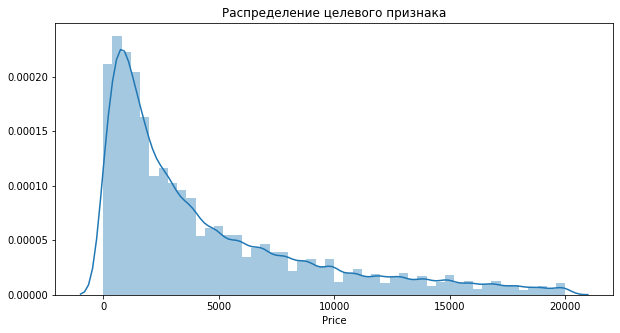

In [13]:
# Распределение целевого признака
plt.figure(figsize=(10,5))
plt.title('Распределение целевого признака')
sns.distplot(df['Price'])

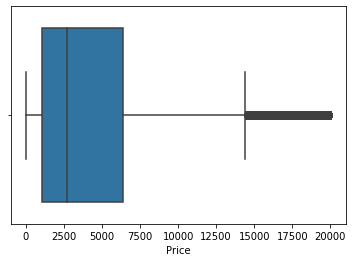

In [14]:
sns.boxplot(df['Price'])

In [15]:
# Удаляю выбросы по цене. Убаляю все что меньше первого квартиля
df=df.loc[(df['Price']>1000) &(df['Price']<20000)]

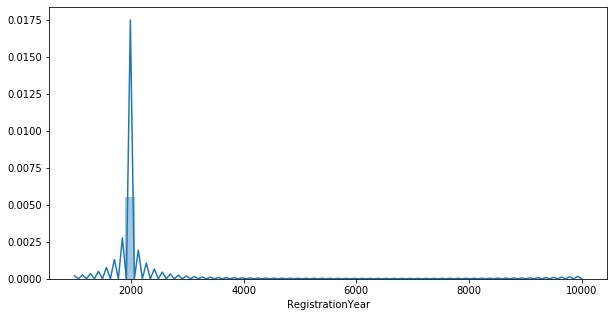

In [16]:
#Распределение машин по годам
plt.figure(figsize=(10,5))
sns.distplot(df['RegistrationYear'])

In [17]:
# Удаляю выбросы по году регистрации все что раньше 1980 и позже 2050 года
df=df.loc[(df['RegistrationYear']<2050) & (df['RegistrationYear']>1980)]

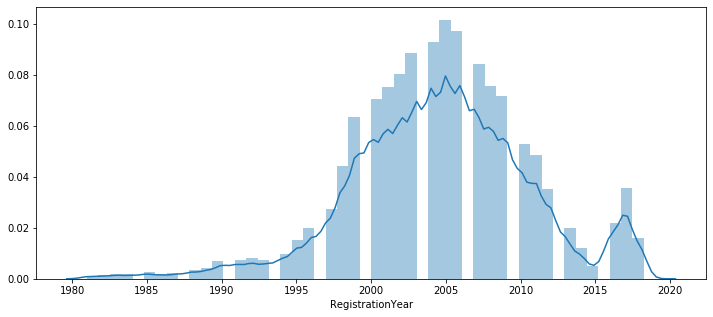

In [18]:
plt.figure(figsize=(12,5))
sns.distplot(df['RegistrationYear'])

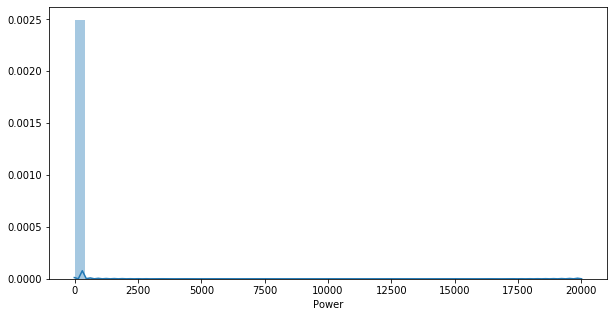

In [19]:
#Распределение по мощности
plt.figure(figsize=(10,5))
sns.distplot(df['Power'])

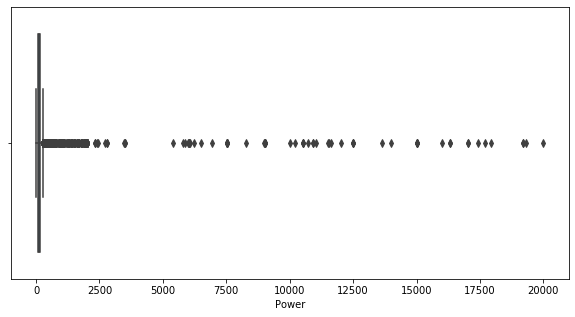

In [20]:
plt.figure(figsize=(10,5))
sns.boxplot(df['Power'])

In [21]:
# Удаляю выбросы по мощности
df=df.loc[(df['Power']>70)&(df['Power']<300)]

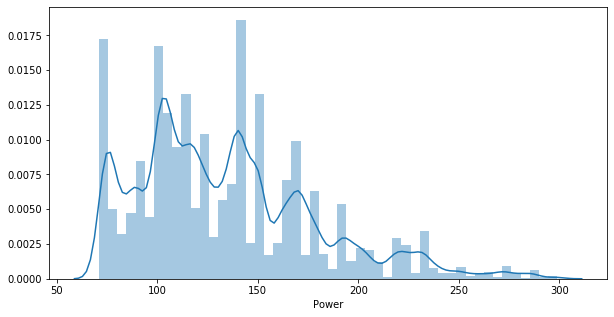

In [22]:
plt.figure(figsize=(10,5))
sns.distplot(df['Power'])

In [23]:
# Удалим столбцы, которые явно не имеют смысла для предсказания цены
del df['LastSeen']
del df['DateCreated']
del df['DateCrawled']
del df['RegistrationMonth']
del df['PostalCode']
del df['NumberOfPictures']

In [24]:
display(df.head())

,index,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,1,18300,coupe,2011,manual,190,null,125000,gasoline,audi,yes
2,2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
6,6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
8,8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,no


## Обучение моделей

In [25]:
#Подготовка признаков порядковым кодированием
#encoder = OrdinalEncoder()
#df[["VehicleType"]] = encoder.fit_transform(df[["VehicleType"]])
#df[["Gearbox"]] = encoder.fit_transform(df[["Gearbox"]])
#df[["Model"]] = encoder.fit_transform(df[["Model"]])
#df[["FuelType"]] = encoder.fit_transform(df[["FuelType"]])
#df[["Brand"]] = encoder.fit_transform(df[["Brand"]])
#df[["NotRepaired"]] = encoder.fit_transform(df[["NotRepaired"]])
#features = df.drop('Price', axis=1)
#target = df['Price']

data_ohe = pd.get_dummies(df, drop_first=True)
target = data_ohe['Price']
features = data_ohe.drop('Price', axis=1)

train_features,valid_features,train_target,valid_target=train_test_split(features,target,test_size=0.25,random_state=1234)


#train, valid = train_test_split(df,,test_size=0.25, random_state=12345)
#test, valid = train_test_split(test_full,test_size=0.5, random_state=42)

#features_train = train.drop(['Exited'], axis=1)
#target_train = train['Exited'] 
#features_valid = valid.drop(['Exited'], axis=1)
#target_valid = valid['Exited'] 
#features_test = test.drop(['Exited'], axis=1)
#target_test = test['Exited'] 


In [26]:
#масштабируем признаки
#numeric = ['VehicleType','Gearbox','Model','FuelType', 'Brand', 'NotRepaired']
#scaler = StandardScaler()
#scaler.fit(train_features[numeric])
#train_features[numeric] = scaler.transform(train_features[numeric])
#valid_features[numeric] = scaler.transform(valid_features[numeric])

In [27]:
#target=df_scaled['Price']
#features=df_scaled.drop(['Price'],axis=1)


#### CatboostRegressor

0:	learn: 4258.4622916	total: 184ms	remaining: 6m 7s
100:	learn: 1767.2249840	total: 22.2s	remaining: 6m 57s
200:	learn: 1674.6251525	total: 44.4s	remaining: 6m 36s
300:	learn: 1620.6216905	total: 1m 6s	remaining: 6m 16s
400:	learn: 1583.2522775	total: 1m 28s	remaining: 5m 53s
500:	learn: 1554.0931717	total: 1m 51s	remaining: 5m 32s
600:	learn: 1529.1612816	total: 2m 13s	remaining: 5m 9s
700:	learn: 1507.1611378	total: 2m 34s	remaining: 4m 47s
800:	learn: 1488.4114629	total: 2m 56s	remaining: 4m 24s
900:	learn: 1471.4835689	total: 3m 19s	remaining: 4m 2s
1000:	learn: 1456.5528219	total: 3m 41s	remaining: 3m 40s
1100:	learn: 1443.1503549	total: 4m 3s	remaining: 3m 18s
1200:	learn: 1429.2993000	total: 4m 25s	remaining: 2m 56s
1300:	learn: 1416.6426267	total: 4m 47s	remaining: 2m 34s
1400:	learn: 1404.7120381	total: 5m 9s	remaining: 2m 12s
1500:	learn: 1393.6797285	total: 5m 31s	remaining: 1m 50s
1600:	learn: 1383.6787851	total: 5m 53s	remaining: 1m 28s
1700:	learn: 1372.7554312	total: 6m

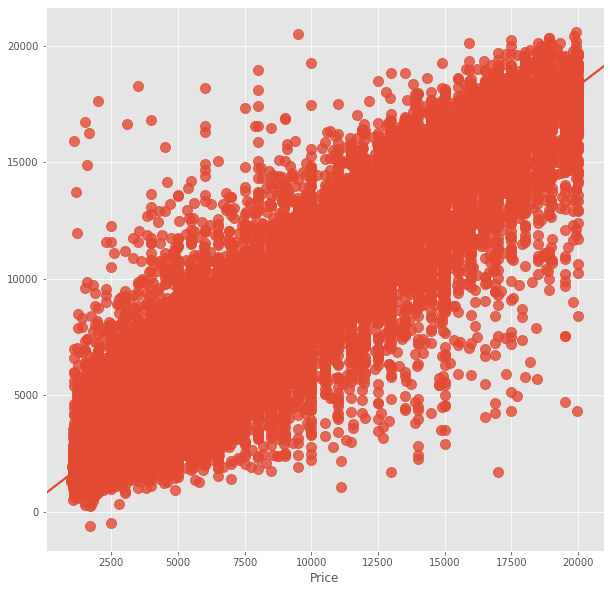

In [28]:
%%time

plt.style.use('ggplot') 
model_cat=CatBoostRegressor(depth=10,
                        iterations=2000,
                        learning_rate=0.1,
                        loss_function='RMSE').fit(train_features,train_target,verbose=100)
predict=model_cat.predict(valid_features)
rmse=mean_squared_error(predict,valid_target)
print('RMSE: ',np.sqrt(rmse))
plt.figure( figsize= (10 , 10 )) 
sns.regplot(valid_target,  predict,  fit_reg= True,  scatter_kws= {"s":  100 })

Text(0.5, 0, 'Importance')

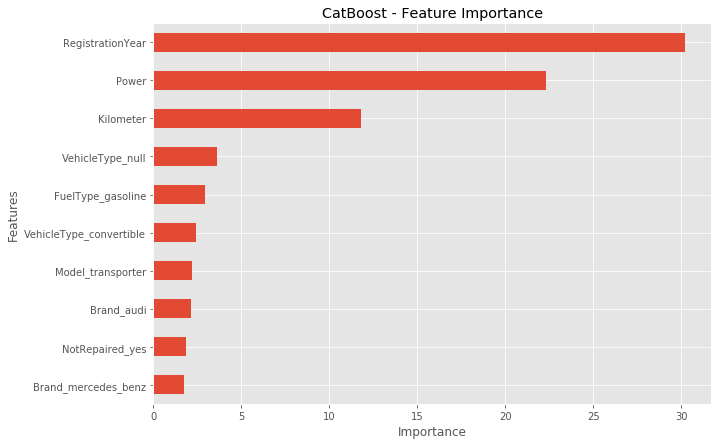

In [29]:
fea_imp = pd.DataFrame({'imp': model_cat.feature_importances_, 'col': train_features.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-10:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')

In [30]:
#Функция для поиска  лучших параметров
def gscv(model, parameters):
    grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 3, n_jobs=None)
    grid.fit(train_features,train_target, verbose=100)    
    # Results from Grid Search
    print("\n========================================================")
    print(" Результаты Grid Search " )
    print("========================================================")    
    
    print("\n The best estimator across ALL searched params:\n",
              grid.best_estimator_)
    
    print("\n The best score across ALL searched params:\n",
              grid.best_score_)
    
    print("\n The best parameters across ALL searched params:\n",
              grid.best_params_)
    
    print("\n ========================================================")   
    


In [ ]:
# Ищем лучшие параметры для CatBoostRegressor
model_catboost = CatBoostRegressor()
parameters_catboost = {'depth'         : [8, 10],
                       'learning_rate' : [0.1, 0.3],
                       'iterations'    : [500,700]
                      }
gscv(model_catboost, parameters_catboost)

0:	learn: 4275.3320441	total: 95.2ms	remaining: 47.5s
100:	learn: 1828.3415100	total: 12s	remaining: 47.6s
200:	learn: 1730.9755245	total: 23.6s	remaining: 35.1s
300:	learn: 1676.0385936	total: 35.1s	remaining: 23.2s
400:	learn: 1639.7025045	total: 46.7s	remaining: 11.5s
499:	learn: 1610.6608050	total: 58.3s	remaining: 0us
0:	learn: 4272.8162619	total: 22.8ms	remaining: 11.4s
100:	learn: 1831.6590234	total: 11.8s	remaining: 46.5s
200:	learn: 1731.9851798	total: 23.4s	remaining: 34.8s
300:	learn: 1680.9713924	total: 35s	remaining: 23.1s
400:	learn: 1643.1373295	total: 46.5s	remaining: 11.5s
499:	learn: 1615.6811939	total: 58.5s	remaining: 0us
0:	learn: 4272.4447955	total: 99.3ms	remaining: 49.5s
100:	learn: 1814.4587200	total: 12.5s	remaining: 49.2s
200:	learn: 1719.4500341	total: 24.9s	remaining: 37s
300:	learn: 1668.3345741	total: 37.3s	remaining: 24.7s
400:	learn: 1631.6881701	total: 49.7s	remaining: 12.3s
499:	learn: 1603.1608648	total: 1m 1s	remaining: 0us
0:	learn: 3714.8832385	to

 Модель CatboostRegressor дала RMSE = 0.33. Также показала, что наиболее влияющими на цену афтомобилей являются год регистрации, мощность и производитель. Лучшими параметрами оказались 'depth': 10, 'iterations': 700, 'learning_rate': 0.1

#### LightgbmRegressor

In [ ]:
%%time

plt.style.use('ggplot') 
model_lgb = LGBMRegressor(depth=8,
                        iterations=2000,
                        learning_rate=0.3,
                        loss_function='RMSE')
model_lgb.fit(train_features,train_target,verbose=100)
predict=model_lgb.predict(valid_features)
rmse=mean_squared_error(predict,valid_target)
print('RMSE: ',np.sqrt(rmse))
plt.figure( figsize= (10 , 10 )) 
sns.regplot(valid_target,  predict,  fit_reg= True,  scatter_kws= {"s":  100 })

In [ ]:
# Ищем лучшие параметры для LGBMRegressor
model_lgbm = LGBMRegressor()
parameters_lgbm = {'depth'         : [8, 10],
                   'learning_rate' : [0.1, 0.3],
                   'iterations'    : [500,700]
                  }
gscv(model_lgbm, parameters_lgbm)
 

## Анализ моделей

Мы рассмотрели 2 модели CatBoostRegressor и LGBMRegressor. CatBoost дала rmse = 0.33 и наилучшие параметры для нее оказались   'depth': 10, 'iterations': 700, 'learning_rate': 0.1 и время обучения чуть больше 6 мин. LGBMRegressor дала rmse = 0.36, лучшие параметры для нее оказались  'depth': 8, 'iterations': 500, 'learning_rate': 0.3 и время обучения составило примерно 11с.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей

###### 